## Question 2

Define the environment

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Grid size
grid_size = 9

# Define positions (goal, start, in/out gates)
start_state = (0, 0)  # Robot starting position
goal_state = (8, 8)   # Goal position
in_portal = (2, 2)    # In gate position
out_portal = (6, 6)   # Out gate position

# Obstacles positions
obstacles = [(1, 3), (2, 3), (3, 3), (3, 2), (3, 1),
             (5, 5), (6, 5), (7, 5), (8, 5), (5, 6), (5, 7), (5, 8)]


# Actions: (Down, Up, Left, Right)
actions = [(1, 0), (-1, 0), (0, -1), (0, 1)]
gamma = 0.9  # Discount factor

# Initialize Value function (V) and Policy (for policy iteration)
V = np.zeros((grid_size, grid_size))
policy = np.zeros((grid_size, grid_size, 2), dtype=int)


Visualize the environment

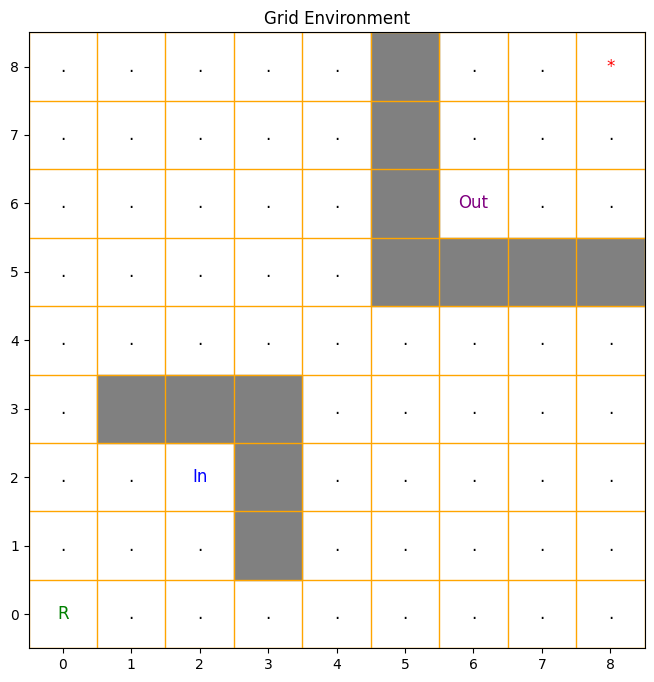

In [29]:
def plot_grid():
    # Create a plot
    plt.figure(figsize=(8, 8))
    
    # Plot the grid cells
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == start_state:
                plt.text(y, x, 'R', ha='center', va='center', fontsize=12, color='green')
            elif (x, y) == goal_state:
                plt.text(y, x, '*', ha='center', va='center', fontsize=12, color='red')
            elif (x, y) == in_portal:
                plt.text(y, x, 'In', ha='center', va='center', fontsize=12, color='blue')
            elif (x, y) == out_portal:
                plt.text(y, x, 'Out', ha='center', va='center', fontsize=12, color='purple')
            elif (x, y) in obstacles:
                plt.gca().add_patch(patches.Rectangle((y - 0.5, x - 0.5), 1, 1, color='gray'))
            else:
                plt.text(y, x, '.', ha='center', va='center', fontsize=12, color='black')
    
    # Set grid lines and aspect
    plt.grid(False)
    plt.xlim(-0.5, grid_size - 0.5)
    plt.ylim(-0.5, grid_size - 0.5)
    plt.gca().set_aspect('equal', adjustable='box')

    # Plot the grid boundaries
    for x in range(grid_size + 1):
        plt.axhline(x - 0.5, color='orange', linewidth=1)
    for y in range(grid_size + 1):
        plt.axvline(y - 0.5, color='orange', linewidth=1)
    
    # Title
    plt.title("Grid Environment")
    plt.show()

# Call the function to plot the grid
plot_grid()


In [30]:
def is_valid_state(s):
    return 0 <= s[0] < grid_size and 0 <= s[1] < grid_size and s not in obstacles

def get_next_state(s, a):
    next_state = (s[0] + a[0], s[1] + a[1])
    if not is_valid_state(next_state):
        return s  # Stay at the same position if invalid
    if next_state == in_portal:
        return out_portal  # Teleport to out portal
    if next_state == out_portal:
        return out_portal  # Stay at out portal
    return next_state


Define Value iteration

In [31]:
def value_iteration():
    global V, policy
    V = np.zeros((grid_size, grid_size))  # Reset Value Function
    policy = np.zeros((grid_size, grid_size, 2), dtype=int)  # Reset Policy
    
    while True:
        delta = 0  # Convergence condition
        for i in range(grid_size):
            for j in range(grid_size):
                s = (i, j)
                if s == goal_state or s in obstacles:  # Skip goal or obstacles
                    continue
                v = V[i, j]
                Q = np.zeros(len(actions))
                
                for a_idx, a in enumerate(actions):
                    next_state = get_next_state(s, a)
                    reward = 1 if next_state == goal_state else 0
                    Q[a_idx] = reward + gamma * V[next_state[0], next_state[1]]
                
                V[i, j] = np.max(Q)
                policy[i, j] = actions[np.argmax(Q)]  # Optimal action
                delta = max(delta, abs(v - V[i, j]))  # Track the largest change
        
        if delta < 1e-4:  # Convergence threshold
            break

    return policy, V


Define Policy iteration

In [32]:
def policy_iteration():
    global V, policy
    policy = np.zeros((grid_size, grid_size, 2), dtype=int)  # Initial arbitrary policy
    V = np.zeros((grid_size, grid_size))  # Reset value function
    
    while True:
        # Policy Evaluation
        while True:
            delta = 0
            for i in range(grid_size):
                for j in range(grid_size):
                    s = (i, j)
                    if s == goal_state or s in obstacles:
                        continue
                    a = tuple(policy[i, j])
                    next_state = get_next_state(s, a)
                    reward = 1 if next_state == goal_state else 0
                    v = V[i, j]
                    V[i, j] = reward + gamma * V[next_state[0], next_state[1]]
                    delta = max(delta, abs(v - V[i, j]))
            if delta < 1e-4:
                break

        # Policy Improvement
        policy_stable = True
        for i in range(grid_size):
            for j in range(grid_size):
                s = (i, j)
                if s == goal_state or s in obstacles:
                    continue
                old_action = tuple(policy[i, j])
                Q = np.zeros(len(actions))
                
                for a_idx, a in enumerate(actions):
                    next_state = get_next_state(s, a)
                    reward = 1 if next_state == goal_state else 0
                    Q[a_idx] = reward + gamma * V[next_state[0], next_state[1]]
                
                new_action = actions[np.argmax(Q)]
                policy[i, j] = new_action
                if old_action != new_action:
                    policy_stable = False
        
        if policy_stable:
            break

    return policy, V


Visualize the policy

In [33]:
def plot_policy(policy, title):
    plt.figure(figsize=(8, 8))
    grid_size = policy.shape[0]

    # Create a grid for quiver plot
    X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
    U = np.zeros_like(X, dtype=float)
    V = np.zeros_like(Y, dtype=float)

    # Fill in direction vectors
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) == goal_state or (i, j) in obstacles or (i, j) == in_portal:
                continue
            action = policy[i, j]
            U[i, j] = action[1]  # Right is positive x direction
            V[i, j] = action[0]  # Down is positive y direction

    # Plot obstacles as solid walls
    for obs in obstacles:
        plt.gca().add_patch(patches.Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1, color='gray'))

    # Adjust quiver plot to ensure arrows are between cells
    plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color='black', width=0.003, headlength=4)

    # Plot grid boundaries as full cells
    for x in range(grid_size + 1):
        plt.axhline(x - 0.5, color='orange', linewidth=1)
    for y in range(grid_size + 1):
        plt.axvline(y - 0.5, color='orange', linewidth=1)

    plt.xlim(-0.5, grid_size - 0.5)
    plt.ylim(-0.5, grid_size - 0.5)
    plt.grid(False)  # Disable default grid
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')

    # Add goal text
    plt.text(goal_state[1], goal_state[0], 'Goal', fontsize=12, ha='center', va='center', color='red')

    # Add start text
    plt.text(start_state[1], start_state[0], 'Start', fontsize=12, ha='center', va='center', color='green')

    # Add portals text
    plt.text(in_portal[1], in_portal[0], 'IN', fontsize=12, ha='center', va='center', color='blue')
    plt.text(out_portal[1], out_portal[0], 'OUT', fontsize=12, ha='center', va='center', color='purple')

    # Show the plot
    plt.show()

Execute the methods and plot

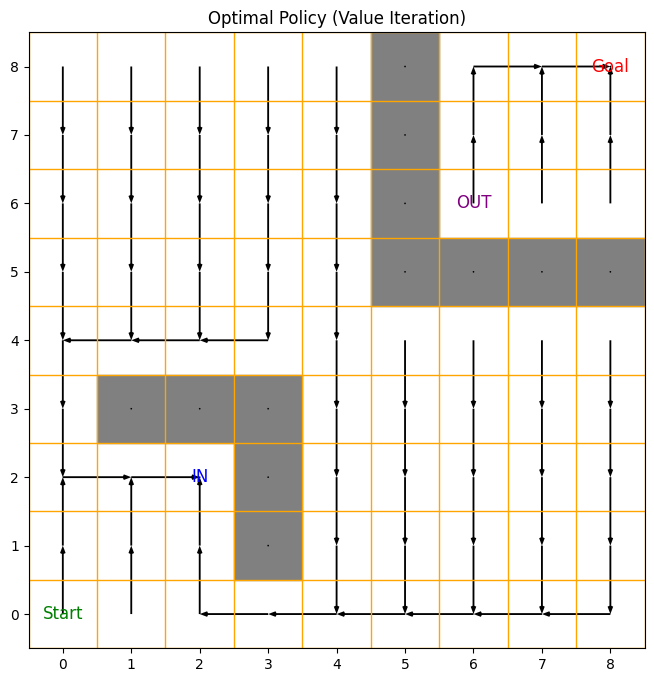

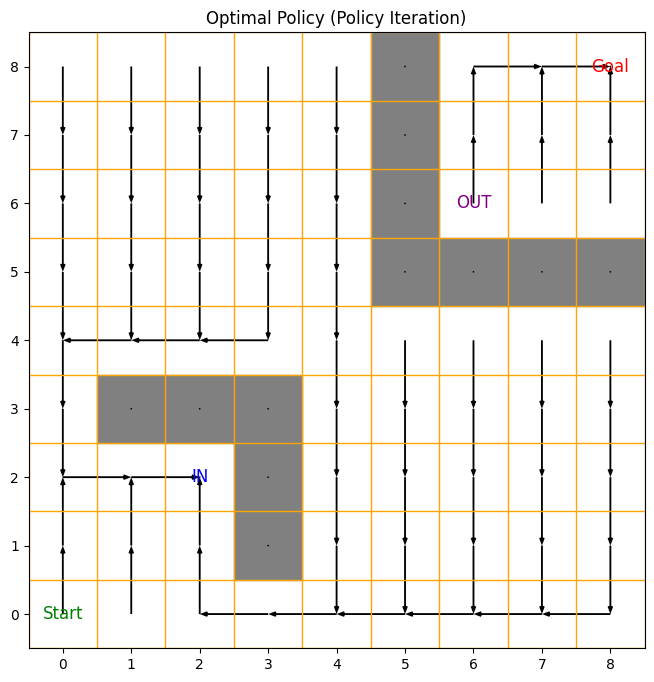

In [34]:
# Run Value Iteration
policy_value_iter, V_value_iter = value_iteration()
plot_policy(policy_value_iter, "Optimal Policy (Value Iteration)")

# Run Policy Iteration
policy_policy_iter, V_policy_iter = policy_iteration()
plot_policy(policy_policy_iter, "Optimal Policy (Policy Iteration)")

# Show plots
plt.show()
